# Early detection of Alzheimer's disease using blood gene expression data
## Design Project
by J. Hariharan and Dr. R. Jothi

In [46]:
import pandas as pd
import numpy as np
import GEOparse
import os
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import csv
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

### Parsing GSE63060 and GSE63061 dataset

In [29]:
dataset_directory = "../DataSets/"
parsed_data_file_suffix = "_parsed_data.csv"

In [30]:
gses = {}

gses["GSE63060"] = GEOparse.get_GEO(filepath="../DataSets/GSE63060_family.soft.gz")
gses["GSE63061"] = GEOparse.get_GEO(filepath="../DataSets/GSE63061_family.soft.gz")

len(gses)

02-Mar-2023 18:34:28 INFO GEOparse - Parsing ../DataSets/GSE63060_family.soft.gz: 
02-Mar-2023 18:34:28 DEBUG GEOparse - DATABASE: GeoMiame
02-Mar-2023 18:34:28 DEBUG GEOparse - SERIES: GSE63060
02-Mar-2023 18:34:28 DEBUG GEOparse - PLATFORM: GPL6947
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539080
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539081
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539082
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539083
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539084
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539085
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539086
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539087
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539088
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539089
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539090
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539091
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539092
02-Mar-2

2

In [31]:
# 1. Finding Gene symbols for the ID_REF values
# 2. Group the rows based on Gene Symbol values
# 3. replace the groups with a single row with Gene Symbol of the group and the Median of the gene expression value

for datasetName in gses:
    gse = gses[datasetName]
    gpl_lookup = []

    for gpl_name, gpl in gse.gpls.items():
        gpl_lookup = gpl.table.filter(["ID", "ILMN_Gene"]).set_index("ID")[
            "ILMN_Gene"].to_dict()

    column_names = ["sample_id", "status", "ethinicity",
                    "age", "gender", "included_in_case_study", "tissue"]
    values = []
    for gsm_name, gsm in gse.gsms.items():
        row = {}
        row[column_names[0]] = gsm_name

        for characteristic in gsm.metadata["characteristics_ch1"]:
            chsplit = characteristic.split(": ")
            row[chsplit[0]] = chsplit[1]

        tempdf = gsm.table.copy(deep=True)
        tempdf["ID_REF"] = tempdf["ID_REF"].apply(
            lambda id_ref: gpl_lookup[id_ref])
        tempdf = tempdf["VALUE"].groupby(tempdf["ID_REF"])
        for key, group in tempdf:
            row[key] = group.median()

        values.append(row)

    dataset = pd.DataFrame.from_dict(values)
    dataset.to_csv(dataset_directory + datasetName + parsed_data_file_suffix, index=False)

### Integrating the parsed datasets

In [168]:
datasets = []
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Loading the parsed data
file_Id = 0
for file in os.listdir(dataset_directory):
    if file.endswith("_parsed_data.csv"):
        file_path = os.path.join(dataset_directory, file)
        dataset = pd.read_csv(file_path, index_col="sample_id")
        x_scaled_values = min_max_scaler.fit_transform(dataset.iloc[:, 6:].values)
        dataset.iloc[:, 6:] = x_scaled_values        
        datasets.append(dataset)


In [169]:
# extract only common columns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

common_columns = datasets[0]
for i in range(1, len(datasets)):
    common_columns = intersection(common_columns, datasets[i])

print("No of Common Columns :", end=" ")
print(len(common_columns))

for i in range(len(datasets)):
    datasets[i] = datasets[i][common_columns]
    print(datasets[i].shape)

master_dataset = pd.concat(datasets)

print(master_dataset.shape)

# Save master dataset
master_dataset.to_csv(dataset_directory+"master_dataset.csv")
master_dataset.head()

No of Common Columns : 12459
(388, 12459)
(329, 12459)
(431, 12459)
(1148, 12459)


,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539409,MCI,57,Female,yes,blood,0.842142,0.141849,0.270089,0.414582,0.366943,...,0.491837,0.362170,0.242994,0.324213,0.382473,0.219812,0.506150,0.564975,0.783020,0.280390
GSM1539410,MCI,59,Female,yes,blood,0.082720,0.217729,0.219648,0.098985,0.546756,...,0.620090,0.154047,0.268210,0.432774,0.485216,0.338584,0.657337,0.897605,0.828350,0.198357
GSM1539411,MCI,63,Female,yes,blood,0.342776,0.419005,0.223242,0.485604,0.707504,...,0.604173,0.602999,0.118003,0.391065,0.495688,0.369816,0.433200,0.567302,0.616342,0.417443
GSM1539412,MCI,65,Female,yes,blood,0.844631,0.278016,0.351760,0.171538,0.396991,...,0.161829,0.081752,0.268977,0.215652,0.411997,0.218022,0.672268,0.741393,0.573071,0.127701
GSM1539413,MCI,66,Female,yes,blood,0.354327,0.100254,0.039218,0.493919,0.163816,...,0.163634,0.318442,0.560799,0.102833,0.306091,0.164445,0.833463,0.565744,0.366652,0.397025


### Min-Max Normalisation of the Master Data

In [170]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaled_values = min_max_scaler.fit_transform(master_dataset.iloc[:, 6:].values)
master_dataset.iloc[:, 6:] = x_scaled_values
master_dataset.to_csv(dataset_directory+"master_dataset.csv")
master_dataset.head()

,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539409,MCI,57,Female,yes,blood,0.842142,0.141849,0.270089,0.414582,0.366943,...,0.491837,0.362170,0.242994,0.324213,0.382473,0.219812,0.506150,0.564975,0.783020,0.280390
GSM1539410,MCI,59,Female,yes,blood,0.082720,0.217729,0.219648,0.098985,0.546756,...,0.620090,0.154047,0.268210,0.432774,0.485216,0.338584,0.657337,0.897605,0.828350,0.198357
GSM1539411,MCI,63,Female,yes,blood,0.342776,0.419005,0.223242,0.485604,0.707504,...,0.604173,0.602999,0.118003,0.391065,0.495688,0.369816,0.433200,0.567302,0.616342,0.417443
GSM1539412,MCI,65,Female,yes,blood,0.844631,0.278016,0.351760,0.171538,0.396991,...,0.161829,0.081752,0.268977,0.215652,0.411997,0.218022,0.672268,0.741393,0.573071,0.127701
GSM1539413,MCI,66,Female,yes,blood,0.354327,0.100254,0.039218,0.493919,0.163816,...,0.163634,0.318442,0.560799,0.102833,0.306091,0.164445,0.833463,0.565744,0.366652,0.397025


### Loading Processed Dataset

In [3]:
### Loading Processed data
master_dataset = pd.read_csv("../DataSets/master_dataset.csv", index_col="sample_id")
master_dataset.shape


(1148, 12459)

In [5]:
master_dataset = master_dataset[(master_dataset["status"] == "AD") | (master_dataset["status"] == "CTL")]
AD_dataset = master_dataset[master_dataset["status"] == "AD"]
CTL_dataset = master_dataset[master_dataset["status"] == "CTL"]
no_of_ad_samples = AD_dataset.shape[0]
no_of_ctl_samples = CTL_dataset.shape[0]
min_no_samples = min(no_of_ad_samples, no_of_ctl_samples)
AD_dataset = AD_dataset.sample(min_no_samples)
CTL_dataset = CTL_dataset.sample(min_no_samples)
master_dataset = pd.concat([AD_dataset, CTL_dataset])

master_dataset["status"].value_counts()

AD     238
CTL    238
Name: status, dtype: int64

### 80-20 Test and Train Split

In [32]:
X = master_dataset.iloc[:, 5:]
Y = master_dataset["status"].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=2222)

In [33]:

print("AD and CTL samples in Training set : ", end="")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print("AD and CTL samples in Testing set : ", end="")
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

AD and CTL samples in Training set : {'AD': 190, 'CTL': 190}
AD and CTL samples in Testing set : {'AD': 48, 'CTL': 48}


### Chi-square Feature Selection

In [34]:
def ChiSquare(X, Y, no_of_features_to_select):
    gene_to_select = []

    chi2 = feature_selection.SelectKBest(feature_selection.chi2, k=no_of_features_to_select)
    chi2.fit_transform(X, Y)
    chi2_support = chi2.get_support()

    for i in range(len(chi2_support)):
        if(chi2_support[i] == True):
            gene_to_select.append(X.columns[i])

    return gene_to_select

#### Method to find the optiminum Number of Genes to select

In [ ]:
chi_square_results = []
no_feature_to_select = 14

while no_feature_to_select <= len(X.columns):
    result = {}
    genes_to_select = ChiSquare(x_train, y_train, no_feature_to_select)
    x_train_with_subset_features = x_train[genes_to_select]
    x_test_with_subset_features = x_test[genes_to_select]

    svm_model = SVC(kernel="linear")
    svm_model.fit(x_train_with_subset_features, y_train)

    train_score = svm_model.score(x_train_with_subset_features, y_train)
    test_score = svm_model.score(x_test_with_subset_features, y_test)

    result["no_of_features"] = no_feature_to_select
    result["train_score"] = train_score
    result["test_score"] = test_score

    chi_square_results.append(result)
    #print(no_feature_to_select)
    no_feature_to_select += 100

chi_square_results = pd.DataFrame.from_dict(chi_square_results)

In [36]:
fig = px.line(chi_square_results, x="no_of_features", y=["train_score", "test_score"])
fig.show()

Optimum no. of genes is found to be top **10814**

In [38]:
chi_square_optimum_genes = ChiSquare(x_train, y_train, 10814)
x_train_with_subset_features = x_train[chi_square_optimum_genes]
x_test_with_subset_features = x_test[chi_square_optimum_genes]

svm_model = SVC(kernel="linear")
svm_model.fit(x_train_with_subset_features, y_train)

train_score = svm_model.score(x_train_with_subset_features, y_train)
test_score = svm_model.score(x_test_with_subset_features, y_test)

print("Training Accuracy : ", end="")
print(train_score)
print("Testing Accuracy : ", end="")
print(test_score)

Training Accuracy : 1.0
Testing Accuracy : 0.9375


#### Saving the 10814 genes for futher analysis

In [44]:
with open('Chi_Square_Selected_Features.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(chi_square_optimum_genes)

### ANOVA Feature Selection

In [47]:
def ANOVA(X, Y, no_feature_to_select):
    anova = SelectKBest(f_classif, k = no_feature_to_select)
    anova.fit(X, Y)

    return anova

#### Method to find Optimum Number of genes to select

In [ ]:
anova_results = []
no_feature_to_select = 14

while no_feature_to_select <= len(X.columns):
    result = {}
    anova_model = ANOVA(x_train, y_train, no_feature_to_select)
    x_train_with_subset_features = anova_model.transform(x_train)
    x_test_with_subset_features = anova_model.transform(x_test)

    svm_model = SVC(kernel="linear")
    svm_model.fit(x_train_with_subset_features, y_train)

    train_score = svm_model.score(x_train_with_subset_features, y_train)
    test_score = svm_model.score(x_test_with_subset_features, y_test)

    result["no_of_features"] = no_feature_to_select
    result["train_score"] = train_score
    result["test_score"] = test_score

    anova_results.append(result)
    print(no_feature_to_select)
    no_feature_to_select += 100

anova_results = pd.DataFrame.from_dict(anova_results)

In [54]:
fig = px.line(anova_results, x="no_of_features", y=["train_score", "test_score"])
fig.show()

Optimum no. of genes is found to be top **10814**

In [55]:
anova_model = ANOVA(x_train, y_train, 10814)
x_train_with_subset_features = anova_model.transform(x_train)
x_test_with_subset_features = anova_model.transform(x_test)

svm_model = SVC(kernel="linear")
svm_model.fit(x_train_with_subset_features, y_train)

train_score = svm_model.score(x_train_with_subset_features, y_train)
test_score = svm_model.score(x_test_with_subset_features, y_test)

print("Train Score : ", end="")
print(train_score)
print("Test Score : ", end="")
print(test_score)

Train Score : 1.0
Test Score : 0.9375


#### Saving the 10814 genes for futher analysis

In [76]:
anova_scores = sorted(list(zip(anova_model.scores_, x_train.columns)), reverse=True)
anova_optimum_genes = []

for entry in anova_scores[:10814]:
    anova_optimum_genes.append(entry[1])

with open('ANOVA_Selected_Features.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(anova_optimum_genes)

### Others

In [180]:
model = RandomForestClassifier(n_estimators=100)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(y_train, y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(y_test, y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8541666666666666


In [181]:
model = AdaBoostClassifier(n_estimators=100)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(y_train, y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(y_test, y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8125


In [309]:
vanilla_X = master_dataset.iloc[:, 6:].values
vanilla_Y = master_dataset["status"].values

vanilla_x_train, vanilla_x_test, vanilla_y_train, vanilla_y_test = train_test_split(vanilla_X, vanilla_Y, test_size=0.30, shuffle=True)

In [310]:
model = AdaBoostClassifier(n_estimators=500)

model.fit(vanilla_x_train, vanilla_y_train)

vanilla_y_train_pred = model.predict(vanilla_x_train)
vanilla_y_test_pred = model.predict(vanilla_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(vanilla_y_train, vanilla_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(vanilla_y_test, vanilla_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.9020979020979021


In [296]:
pca_model = PCA(n_components=30)
pca_model.fit(master_dataset.iloc[:, 6:])
pca_X = pca_model.transform(master_dataset.iloc[:, 6:])
pca_Y = master_dataset["status"].values

In [297]:
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(pca_X, pca_Y, test_size=0.10, shuffle=True)

In [299]:
model = RandomForestClassifier(n_estimators=100)

model.fit(pca_x_train, pca_y_train)

pca_y_train_pred = model.predict(pca_x_train)
pca_y_test_pred = model.predict(pca_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_train, pca_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_test, pca_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.75


In [314]:
model = AdaBoostClassifier(n_estimators=100)

model.fit(pca_x_train, pca_y_train)

pca_y_train_pred = model.predict(pca_x_train)
pca_y_test_pred = model.predict(pca_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_train, pca_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_test, pca_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8333333333333334


In [316]:
#Label encoding
def LabelEncoding(Y): 
    le = preprocessing.LabelEncoder()
    le.fit(Y)
    Y = le.transform(Y)
    return Y

y_test = LabelEncoding(y_test)
y_train = LabelEncoding(y_train)

y_test = tf.one_hot(y_test, depth=1)
y_train = tf.one_hot(y_train, depth=1)

print(y_test)

tf.Tensor(
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]], shape=(48, 1), dtype=float32)


In [323]:
dnn_model = tf.keras.models.Sequential()
dnn_model.add(tf.keras.layers.Dense(6, activation="relu", input_shape=(K,)))
dnn_model.add(tf.keras.layers.Dense(5, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(5, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

dnn_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])
dnn_results = dnn_model.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test))

Epoch 1/50


/Users/hari/miniconda/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-03-03 20:28:32.687894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.7220

2023-03-03 20:28:34.783880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 3s 19ms/step - loss: 0.6465 - accuracy: 0.7220 - val_loss: 0.5514 - val_accuracy: 0.8125
Epoch 2/50
86/86 [==============================] - 1s 14ms/step - loss: 0.6051 - accuracy: 0.7944 - val_loss: 0.5428 - val_accuracy: 0.8958
Epoch 3/50
86/86 [==============================] - 1s 13ms/step - loss: 0.5868 - accuracy: 0.8061 - val_loss: 0.5314 - val_accuracy: 0.8958
Epoch 4/50
86/86 [==============================] - 1s 13ms/step - loss: 0.5664 - accuracy: 0.8084 - val_loss: 0.5259 - val_accuracy: 0.8958
Epoch 5/50
86/86 [==============================] - 1s 13ms/step - loss: 0.5447 - accuracy: 0.8271 - val_loss: 0.4783 - val_accuracy: 0.8958
Epoch 6/50
86/86 [==============================] - 1s 13ms/step - loss: 0.5318 - accuracy: 0.8271 - val_loss: 0.5138 - val_accuracy: 0.8958
Epoch 7/50
86/86 [==============================] - 1s 13ms/step - loss: 0.5044 - accuracy: 0.8294 - val_loss: 0.4581 - val_accuracy: 0.8958
Epoch 8/50
86/86 [======

In [187]:
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=2, activation="relu", input_shape=(K, K)))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=2, activation="relu"))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(30, activation="relu"))
cnn_model.add(tf.keras.layers.Dense(2, activation="softmax"))

cnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnn_results = dnn_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test))

Epoch 1/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0835 - accuracy: 0.9766 - val_loss: 0.4065 - val_accuracy: 0.8125
Epoch 2/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0865 - accuracy: 0.9743 - val_loss: 0.3847 - val_accuracy: 0.8542
Epoch 3/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0964 - accuracy: 0.9720 - val_loss: 0.4734 - val_accuracy: 0.7917
Epoch 4/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0710 - accuracy: 0.9836 - val_loss: 0.3896 - val_accuracy: 0.8542
Epoch 5/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0604 - accuracy: 0.9860 - val_loss: 0.3997 - val_accuracy: 0.8333
Epoch 6/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0574 - accuracy: 0.9883 - val_loss: 0.5024 - val_accuracy: 0.7708
Epoch 7/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0700 - accuracy: 0.9836 - val_loss: 0.4402 - val_accuracy: 0.8333
Epoch 

KeyboardInterrupt: 

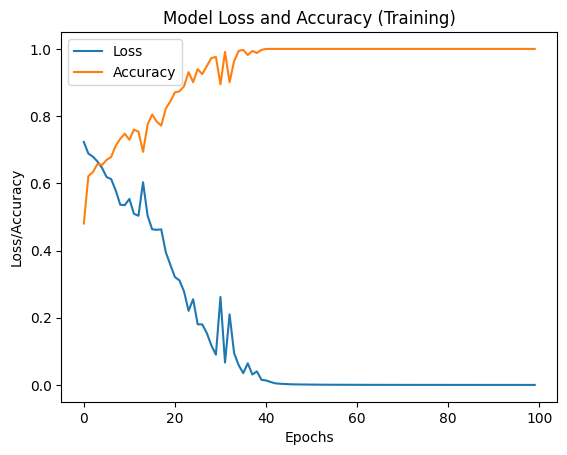

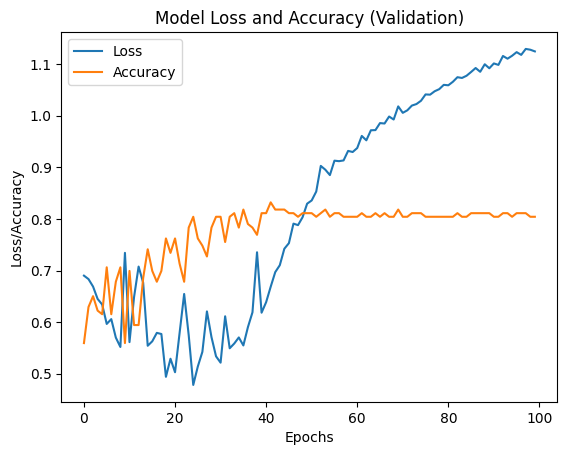

In [112]:
#Plotting the training results
import matplotlib.pyplot as plt
plt.plot(dnn_results.history["loss"])
plt.plot(dnn_results.history["accuracy"])
plt.title("Model Loss and Accuracy (Training)")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(["Loss", "Accuracy"])
plt.show()

#Plotting the testing results
import matplotlib.pyplot as plt
plt.plot(dnn_results.history["val_loss"])
plt.plot(dnn_results.history["val_accuracy"])
plt.title("Model Loss and Accuracy (Validation)")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(["Loss", "Accuracy"])
plt.show()